In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

# Dataset Information:

This dataset consists of Monte Carlo (MC) generated data simulating high-energy gamma particle registration in a Cherenkov gamma telescope using imaging techniques. The telescope detects gamma rays by capturing the Cherenkov radiation emitted by charged particles formed in electromagnetic showers initiated by gamma interactions in the atmosphere.

The recorded data include pulses from Cherenkov photons impacting the photomultiplier tubes arranged in a plane (the camera). Depending on the gamma energy, anywhere from a few hundred to 10,000 photons are collected, forming a shower image that helps distinguish between gamma-initiated showers (signal) and hadronic showers caused by cosmic rays (background).

After pre-processing, the shower image generally appears as an elongated cluster, with its long axis pointing toward the camera center if the telescope is aligned with a point source. A principal component analysis (PCA) is performed to determine correlation axes and define an ellipse, aiding in classification. Features such as Hillas parameters, asymmetry along the major axis, and cluster extent further assist in discrimination.

The data was produced by the Monte Carlo simulation program Corsika, detailed in:

D. Heck et al., CORSIKA: A Monte Carlo Code to Simulate Extensive Air Showers, Forschungszentrum Karlsruhe FZKA 6019 (1998).
http://rexa.info/paper?id=ac6e674e9af20979b23d3ed4521f1570765e8d68
Simulation parameters enabled the detection of events with **energies below 50 GeV

src:

[https://archive.ics.uci.edu/dataset/159/magic+gamma+telescope]

# Data Preperation

In [2]:
cols = ["fLength", "fWidth", "fSize", "fConc", "fConc1", "fAsym", "fM3Long", "fM3Trans", "fAlpha", "fDist", "class"]
url = "https://raw.githubusercontent.com/usernameneo/Data-Science-Projects/refs/heads/main/fcc-MAGIC/magic04.data"
df = pd.read_csv(url, names=cols)
df.head()

fLength    fWidth   fSize   fConc  fConc1     fAsym  fM3Long  fM3Trans  \
0   28.7967   16.0021  2.6449  0.3918  0.1982   27.7004  22.0110   -8.2027   
1   31.6036   11.7235  2.5185  0.5303  0.3773   26.2722  23.8238   -9.9574   
2  162.0520  136.0310  4.0612  0.0374  0.0187  116.7410 -64.8580  -45.2160   
3   23.8172    9.5728  2.3385  0.6147  0.3922   27.2107  -6.4633   -7.1513   
4   75.1362   30.9205  3.1611  0.3168  0.1832   -5.5277  28.5525   21.8393   

    fAlpha     fDist class  
0  40.0920   81.8828     g  
1   6.3609  205.2610     g  
2  76.9600  256.7880     g  
3  10.4490  116.7370     g  
4   4.6480  356.4620     g

In [3]:
df["class"].unique()

array(['g', 'h'], dtype=object)

In [4]:
df["class"] = (df["class"] == "g").astype(int)
df.head()

fLength    fWidth   fSize   fConc  fConc1     fAsym  fM3Long  fM3Trans  \
0   28.7967   16.0021  2.6449  0.3918  0.1982   27.7004  22.0110   -8.2027   
1   31.6036   11.7235  2.5185  0.5303  0.3773   26.2722  23.8238   -9.9574   
2  162.0520  136.0310  4.0612  0.0374  0.0187  116.7410 -64.8580  -45.2160   
3   23.8172    9.5728  2.3385  0.6147  0.3922   27.2107  -6.4633   -7.1513   
4   75.1362   30.9205  3.1611  0.3168  0.1832   -5.5277  28.5525   21.8393   

    fAlpha     fDist  class  
0  40.0920   81.8828      1  
1   6.3609  205.2610      1  
2  76.9600  256.7880      1  
3  10.4490  116.7370      1  
4   4.6480  356.4620      1

Class Values
The only class values are either "g" for gamma particles or "h" for hadron particles. In order to assist in computation of our data, these will be converted to binary values, 0 for hadrons and 1 for gamma.

We will use the features of the DataFrame to determine wheather a recorded particle is a gamma or a hadron particle.

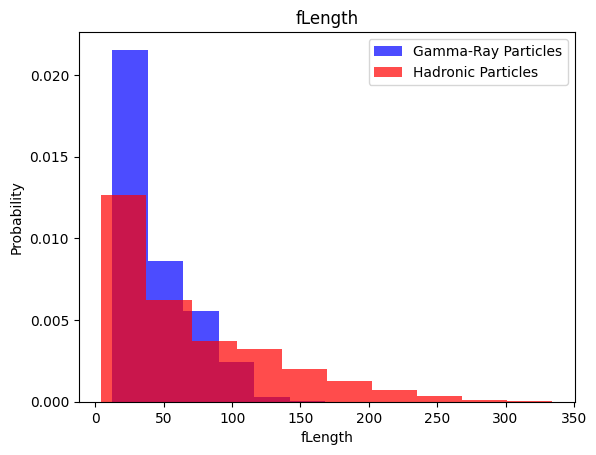

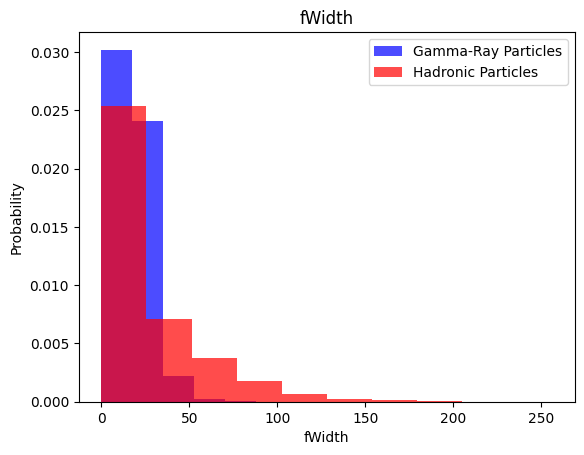

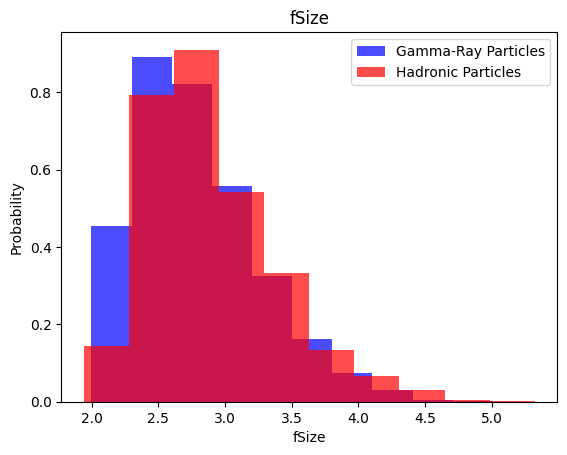

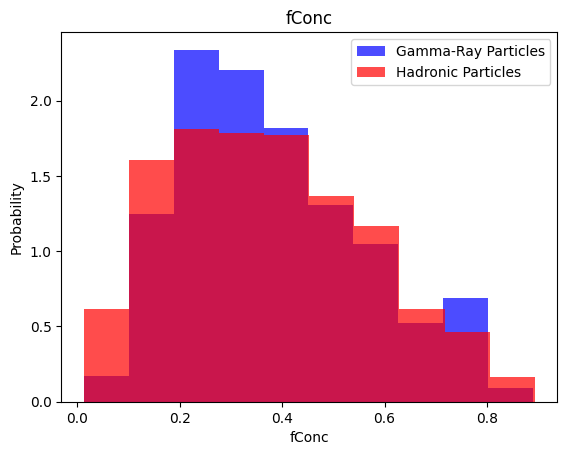

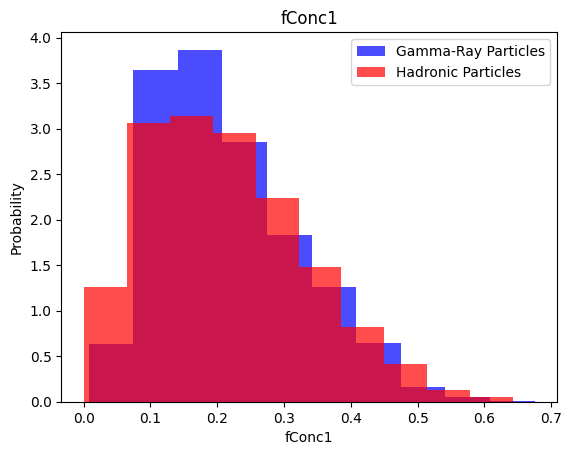

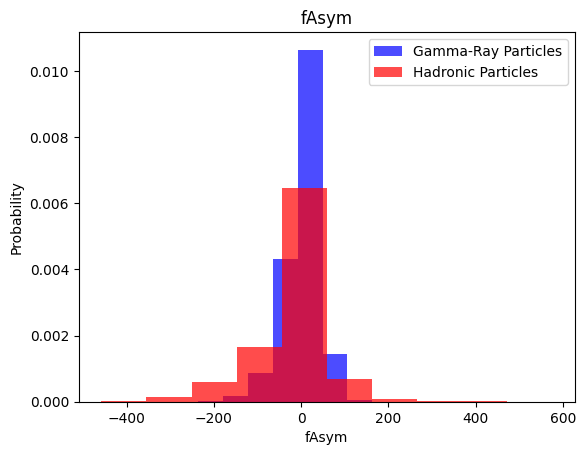

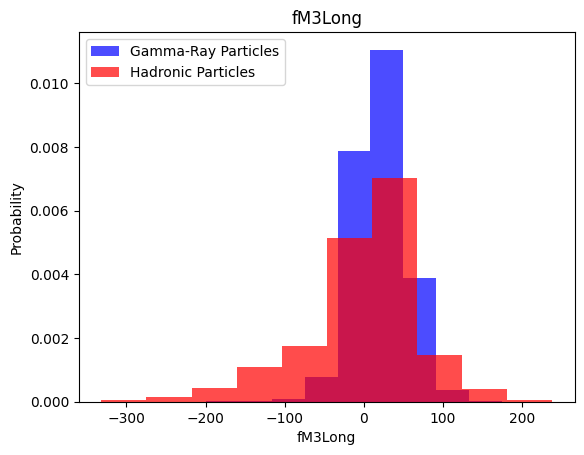

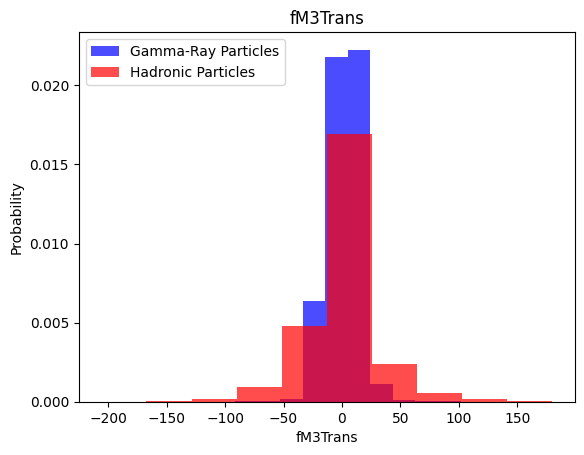

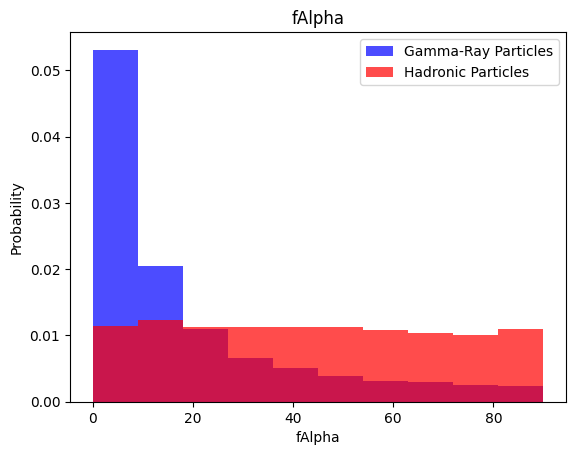

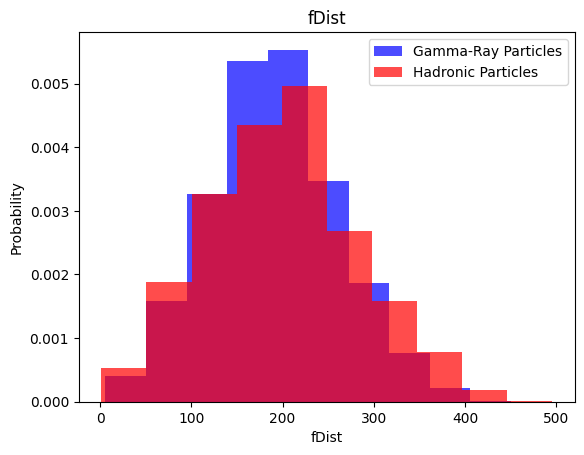

In [5]:
for col in cols[:-1]:
    plt.hist(df[df["class"]==1][col], color="blue", label="Gamma-Ray Particles", alpha=0.7, density=True)
    plt.hist(df[df["class"]==0][col], color="red", label="Hadronic Particles", alpha=0.7, density=True)
    plt.title(col)
    plt.ylabel("Probability")
    plt.xlabel(col)
    plt.legend()
    plt.show()

# Train, Validation and Test datasets

In [6]:
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

/home/codespace/.python/current/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [7]:
def scale_dataset(dataframe, oversample=False):
    X = dataframe[dataframe.columns[:-1]].values
    y = dataframe[dataframe.columns[-1]].values

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    if oversample:
        ros = RandomOverSampler()
        X, y = ros.fit_resample(X, y)

    data = np.hstack((X, np.reshape(y, (-1, 1))))
    return data, X, y

In [8]:
print("Gamma", len(train[train["class"]==1]))
print("Hadron:", len(train[train["class"]==0]))

Gamma 7400
Hadron: 4012


In [9]:
train, X_train, y_train = scale_dataset(train, oversample=True)
val, X_val, y_val = scale_dataset(val, oversample=False)
test, X_test, y_test = scale_dataset(test, oversample=False)

In [10]:
print("Total:", len(y_train))
print("Gamma:", sum(y_train==1))
print("Hadron:", sum(y_train==0))

Total: 14800
Gamma: 7400
Hadron: 7400


# Classification Models

## K-Nearest Neighbors

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

y_predicts = knn_model.predict(X_test)
print(classification_report(y_test, y_predicts))

              precision    recall  f1-score   support

           0       0.71      0.73      0.72      1285
           1       0.86      0.85      0.86      2519

    accuracy                           0.81      3804
   macro avg       0.79      0.79      0.79      3804
weighted avg       0.81      0.81      0.81      3804



## Naive Bayes

In [12]:
from sklearn.naive_bayes import GaussianNB

nb_model = GaussianNB()
nb_model = nb_model.fit(X_train, y_train)

y_predicts = nb_model.predict(X_test)
print(classification_report(y_test, y_predicts))

              precision    recall  f1-score   support

           0       0.62      0.41      0.49      1285
           1       0.74      0.87      0.80      2519

    accuracy                           0.71      3804
   macro avg       0.68      0.64      0.65      3804
weighted avg       0.70      0.71      0.70      3804



## Logistic Progression

In [13]:
from sklearn.linear_model import LogisticRegression

lg_model = LogisticRegression()
lg_model = lg_model.fit(X_train, y_train)

y_predicts = lg_model.predict(X_test)
print(classification_report(y_test, y_predicts))

              precision    recall  f1-score   support

           0       0.65      0.71      0.68      1285
           1       0.84      0.81      0.83      2519

    accuracy                           0.77      3804
   macro avg       0.75      0.76      0.75      3804
weighted avg       0.78      0.77      0.78      3804



## Support Vector Machine

In [14]:
from sklearn.svm import SVC

svm_model = SVC()
svm_model = svm_model.fit(X_train, y_train)

y_predicts = svm_model.predict(X_test)
print(classification_report(y_test, y_predicts))

              precision    recall  f1-score   support

           0       0.79      0.79      0.79      1285
           1       0.89      0.89      0.89      2519

    accuracy                           0.86      3804
   macro avg       0.84      0.84      0.84      3804
weighted avg       0.86      0.86      0.86      3804



# Deep Learning

## Neural Network

In [15]:
import tensorflow as tf

2025-05-30 07:39:22.785820: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-30 07:39:22.792727: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-30 07:39:22.810212: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748590762.846689   74785 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748590762.855459   74785 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748590762.877470   74785 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [16]:
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    ax1.plot(history.history["loss"], label="loss")
    ax1.plot(history.history["val_loss"], label="val_loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Binary Crossentropy")
    ax1.grid(True)

    ax2.plot(history.history["loss"], label="loss")
    ax2.plot(history.history["val_accuracy"], label="val_accuracy")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.grid(True)

    plt.show()

In [17]:
def train_model(X_train, y_train, n_nodes, dropout_prob, lr, batch_size, epochs):
    nn_model = tf.keras.Sequential([
        tf.keras.layers.Dense(n_nodes, activation="relu", input_shape=(10,)),
        tf.keras.layers.Dropout(dropout_prob),
        tf.keras.layers.Dense(n_nodes, activation="relu"),
        tf.keras.layers.Dropout(dropout_prob),
        tf.keras.layers.Dense(n_nodes, activation="relu"),
        tf.keras.layers.Dropout(dropout_prob),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ])

    nn_model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss="binary_crossentropy",
                    metrics=["accuracy"]
                    )
    
    history = nn_model.fit(
        X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, 
        verbose=0
    )
    
    return nn_model, history   

nodes: 16, droupout: 0, lr: 0.01, batch size 32


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-05-30 07:39:24.783375: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


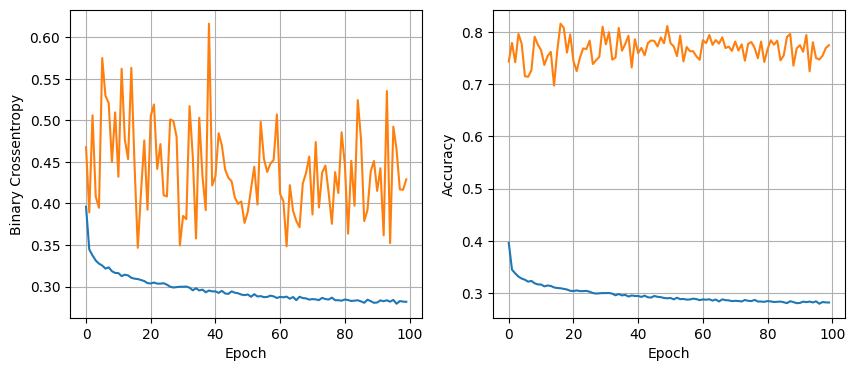

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8725 - loss: 0.3378  
nodes: 16, droupout: 0, lr: 0.01, batch size 64


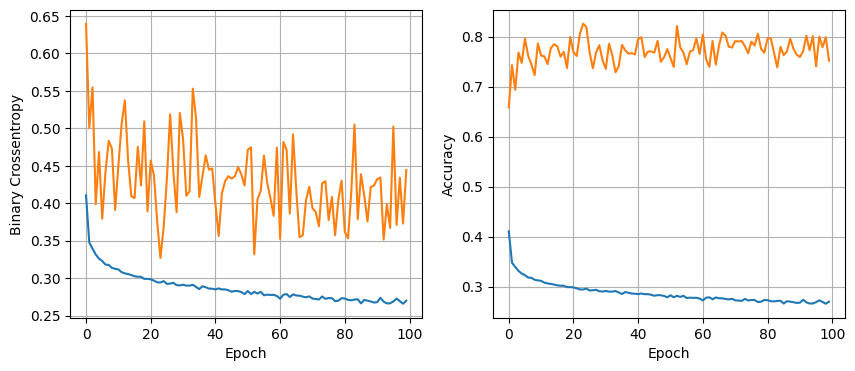

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8693 - loss: 0.3436  
nodes: 16, droupout: 0, lr: 0.01, batch size 128


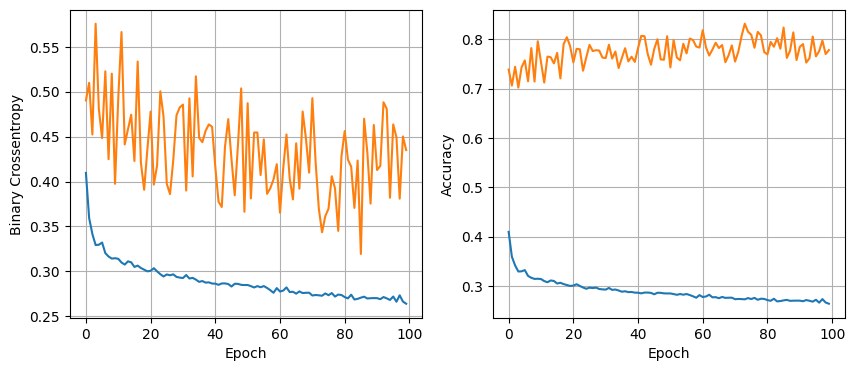

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8699 - loss: 0.3334  
nodes: 16, droupout: 0, lr: 0.005, batch size 32


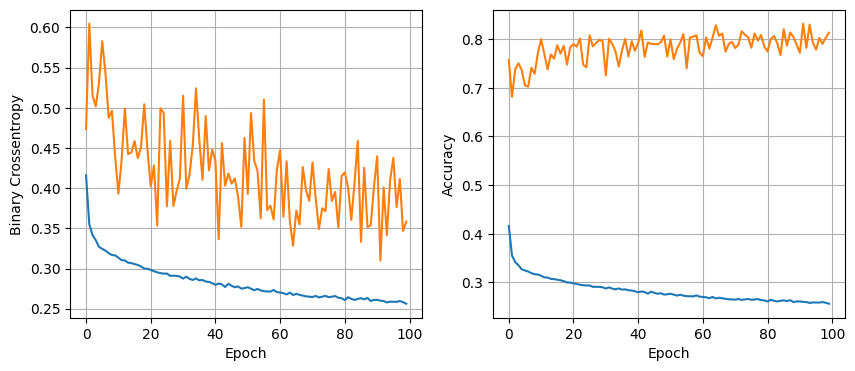

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8697 - loss: 0.3365
nodes: 16, droupout: 0, lr: 0.005, batch size 64


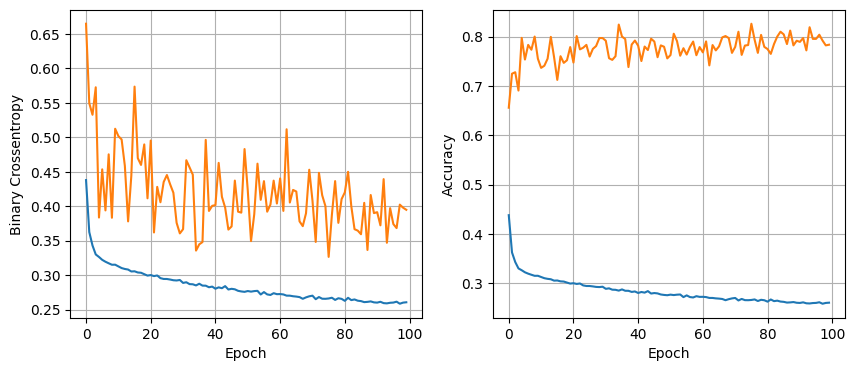

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8710 - loss: 0.3470
nodes: 16, droupout: 0, lr: 0.005, batch size 128


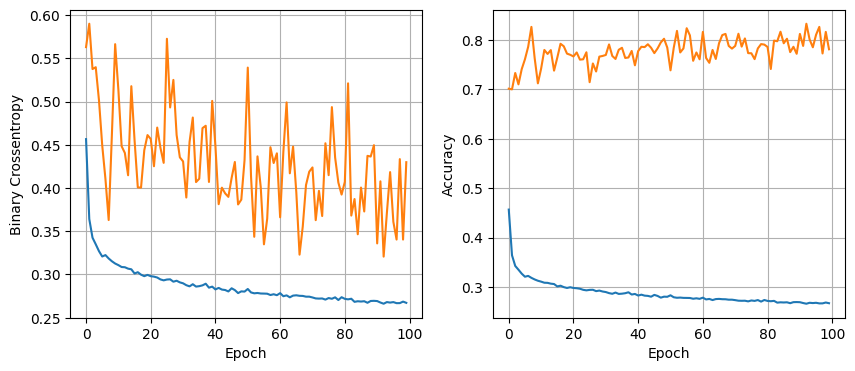

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8727 - loss: 0.3356
nodes: 16, droupout: 0, lr: 0.001, batch size 32


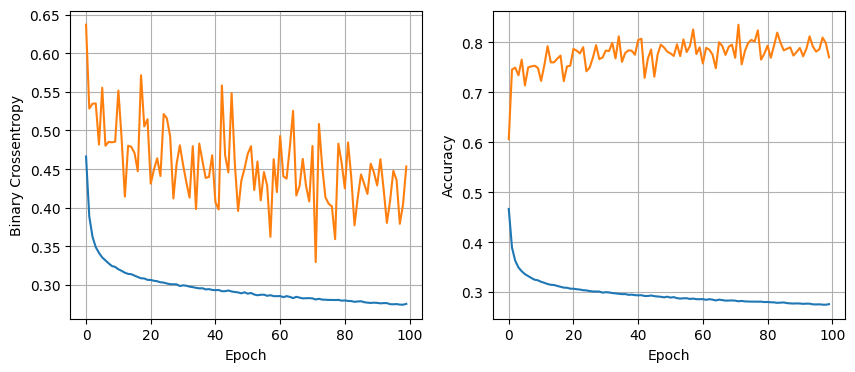

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8737 - loss: 0.3200  
nodes: 16, droupout: 0, lr: 0.001, batch size 64


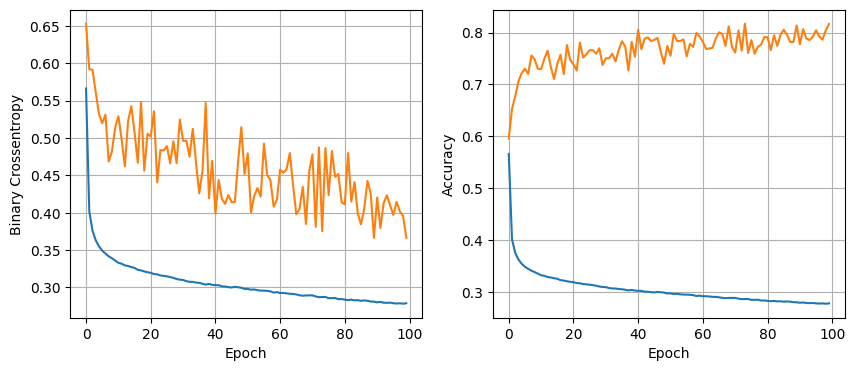

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8700 - loss: 0.3179  
nodes: 16, droupout: 0, lr: 0.001, batch size 128


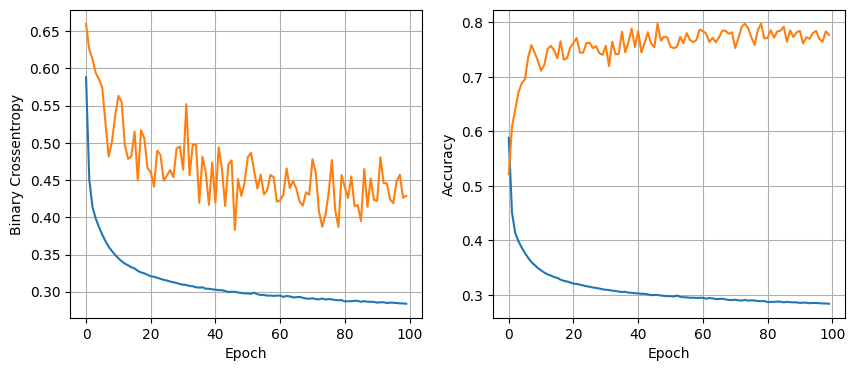

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8713 - loss: 0.3151  
nodes: 16, droupout: 0.2, lr: 0.01, batch size 32


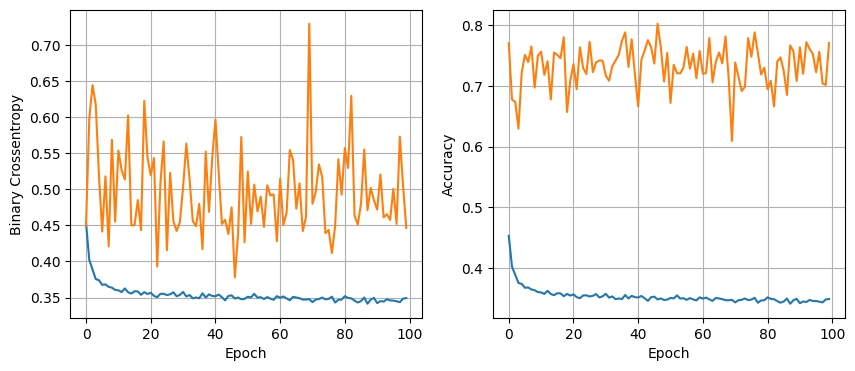

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8675 - loss: 0.3194  
nodes: 16, droupout: 0.2, lr: 0.01, batch size 64


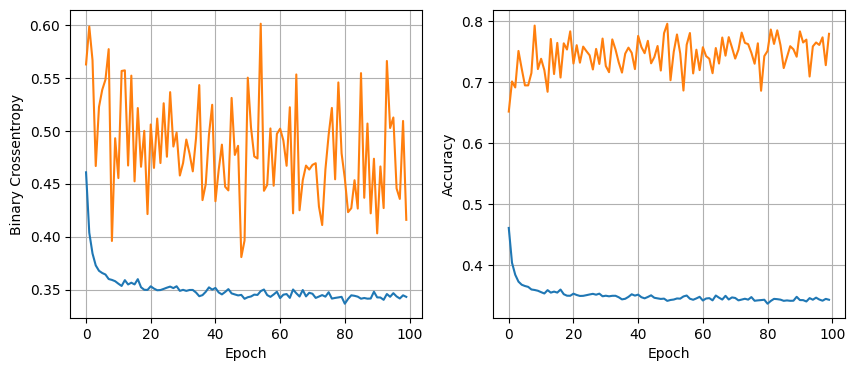

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8679 - loss: 0.3272  
nodes: 16, droupout: 0.2, lr: 0.01, batch size 128


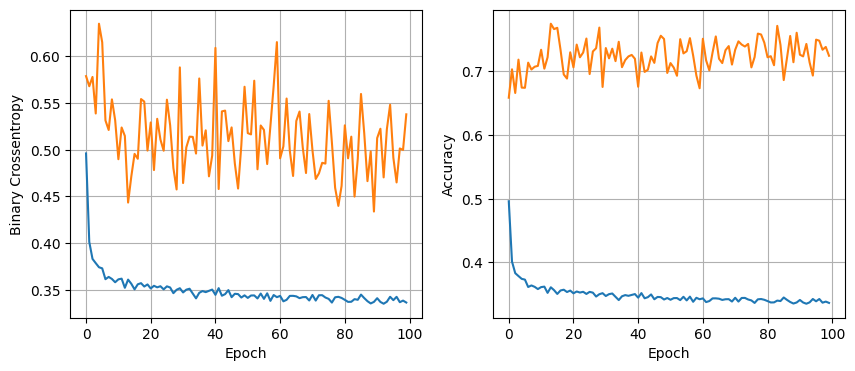

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8708 - loss: 0.3223  
nodes: 16, droupout: 0.2, lr: 0.005, batch size 32


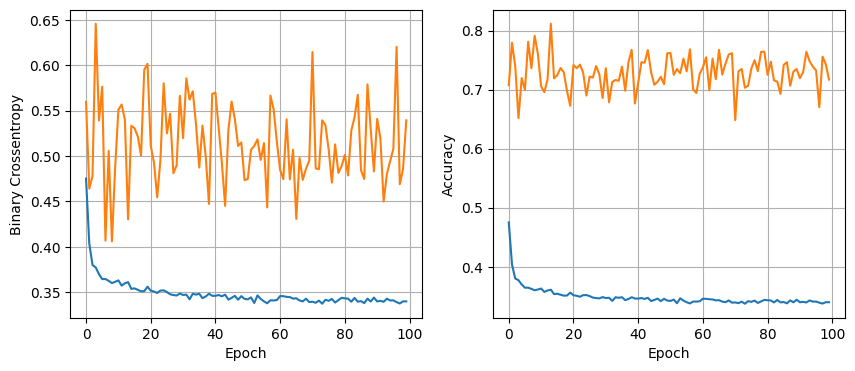

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8684 - loss: 0.3221  
nodes: 16, droupout: 0.2, lr: 0.005, batch size 64


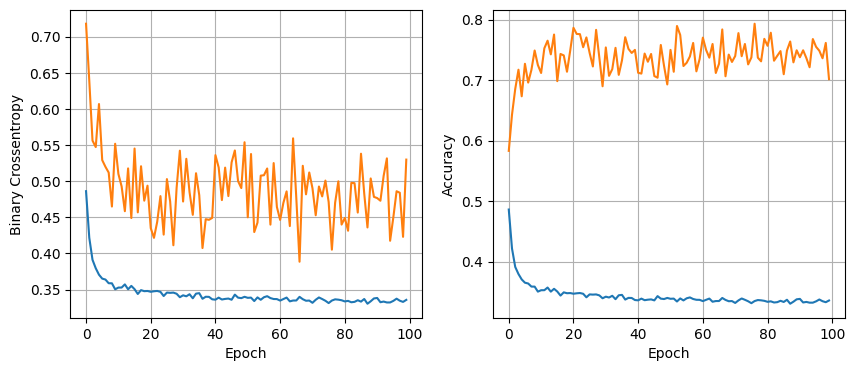

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8626 - loss: 0.3213
nodes: 16, droupout: 0.2, lr: 0.005, batch size 128


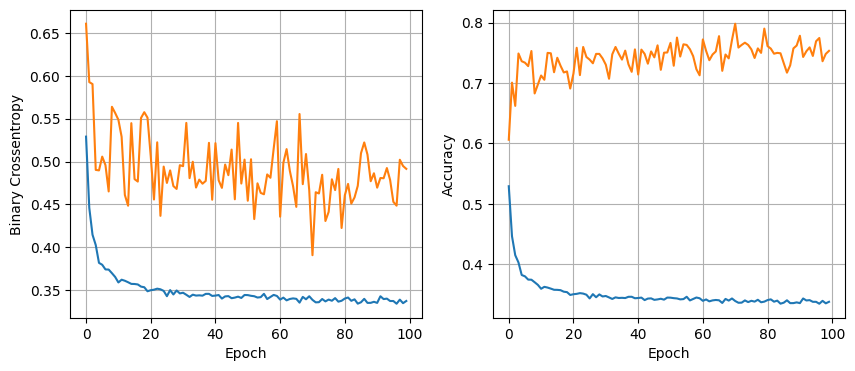

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8647 - loss: 0.3240  
nodes: 16, droupout: 0.2, lr: 0.001, batch size 32


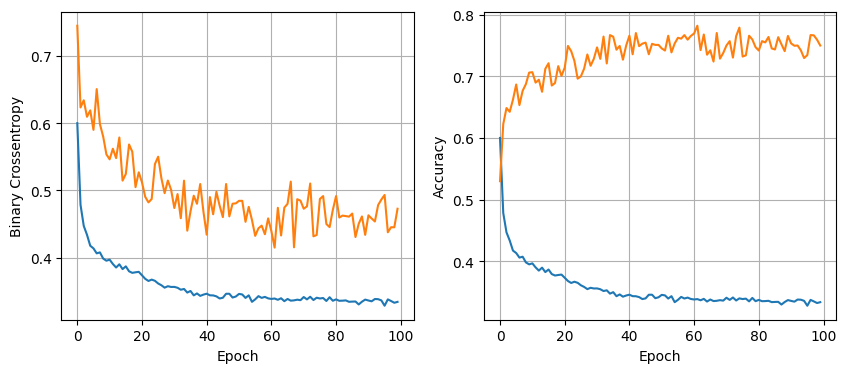

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8629 - loss: 0.3145  
nodes: 16, droupout: 0.2, lr: 0.001, batch size 64


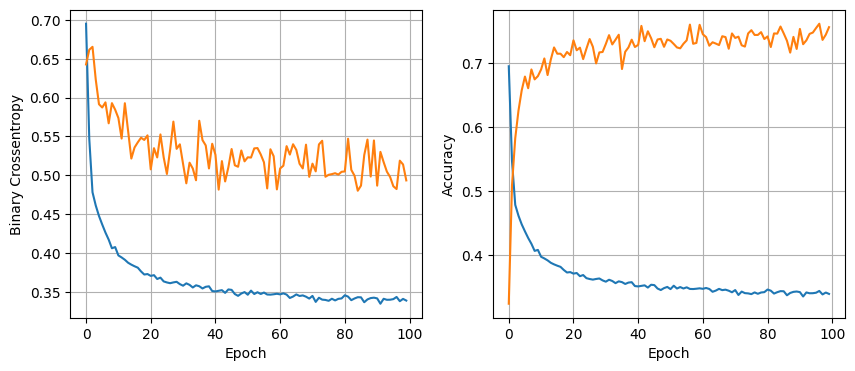

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8659 - loss: 0.3235  
nodes: 16, droupout: 0.2, lr: 0.001, batch size 128


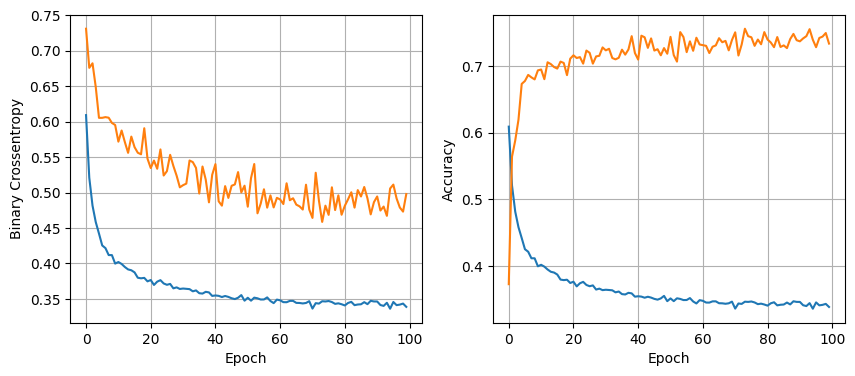

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8703 - loss: 0.3236  
nodes: 32, droupout: 0, lr: 0.01, batch size 32


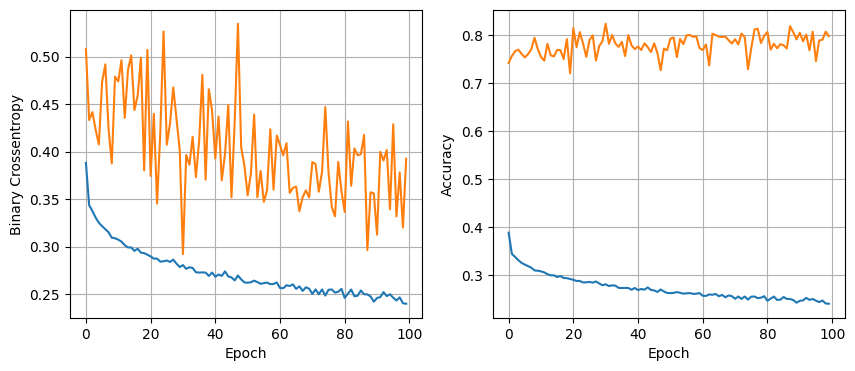

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8728 - loss: 0.4071  
nodes: 32, droupout: 0, lr: 0.01, batch size 64


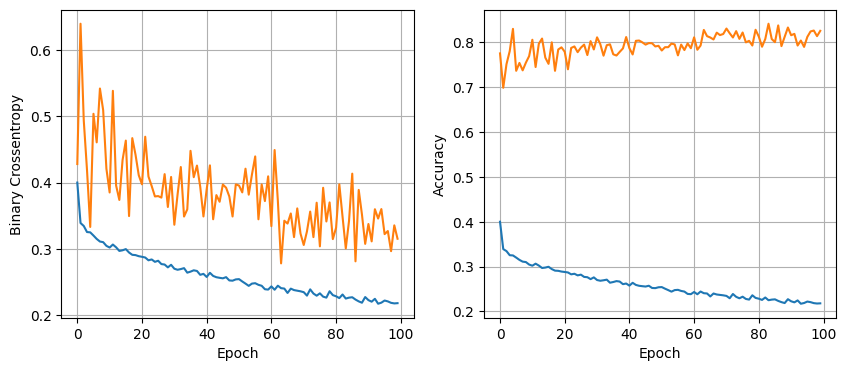

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8677 - loss: 0.4651  
nodes: 32, droupout: 0, lr: 0.01, batch size 128


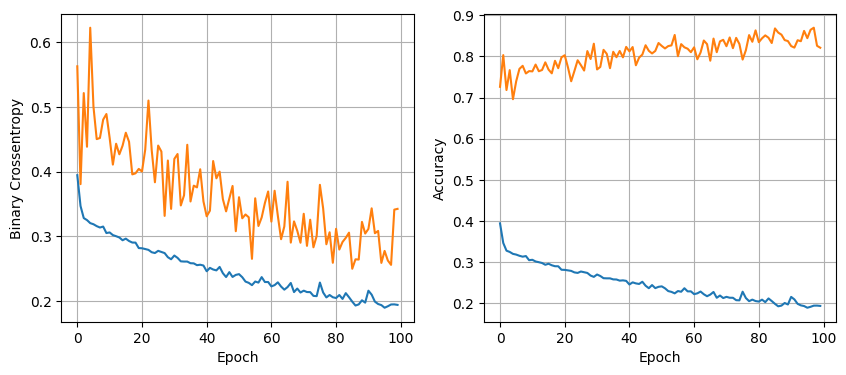

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8566 - loss: 0.5292
nodes: 32, droupout: 0, lr: 0.005, batch size 32


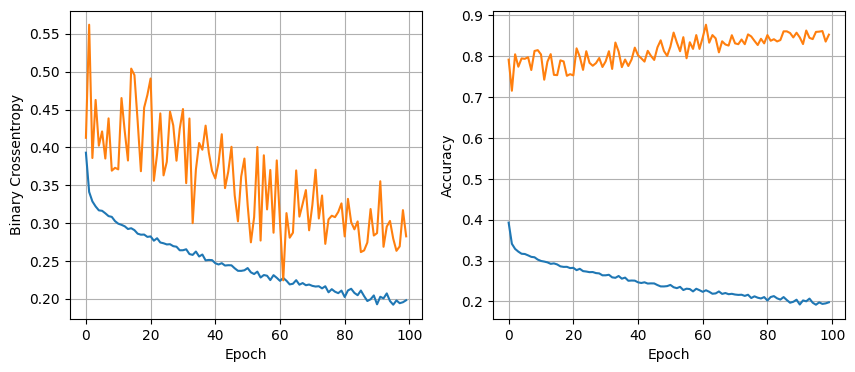

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8687 - loss: 0.4867
nodes: 32, droupout: 0, lr: 0.005, batch size 64


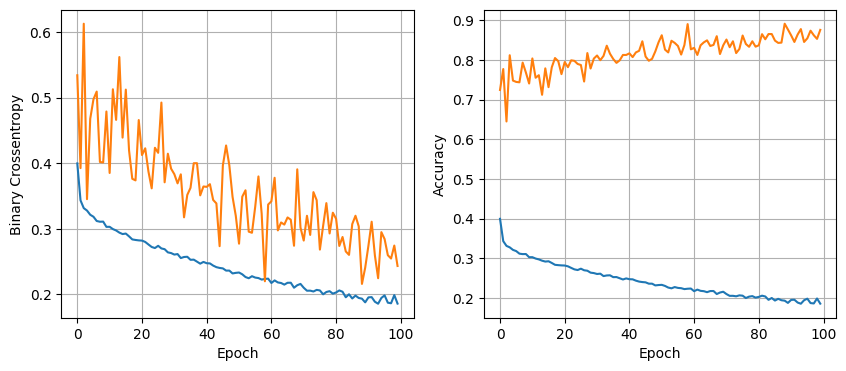

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8573 - loss: 0.4919  
nodes: 32, droupout: 0, lr: 0.005, batch size 128


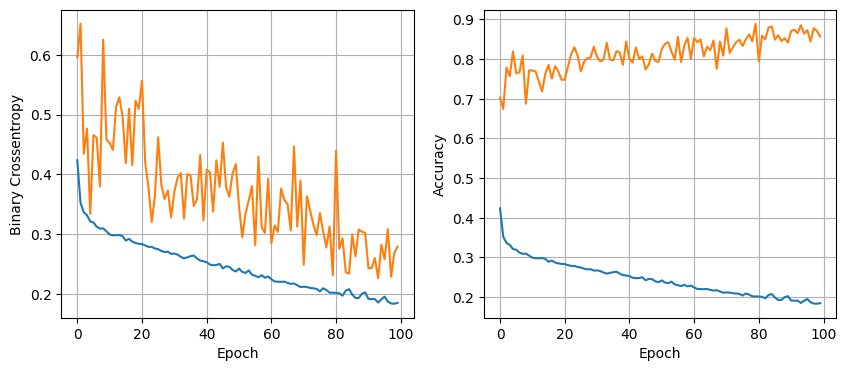

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8772 - loss: 0.4061
nodes: 32, droupout: 0, lr: 0.001, batch size 32


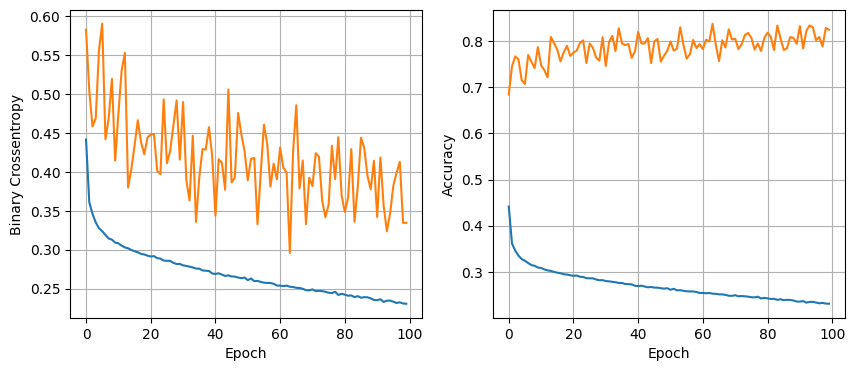

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8792 - loss: 0.3384
nodes: 32, droupout: 0, lr: 0.001, batch size 64


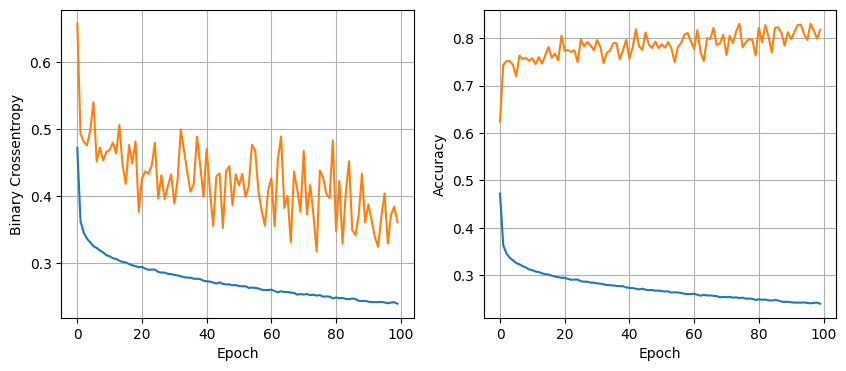

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8703 - loss: 0.3411  
nodes: 32, droupout: 0, lr: 0.001, batch size 128


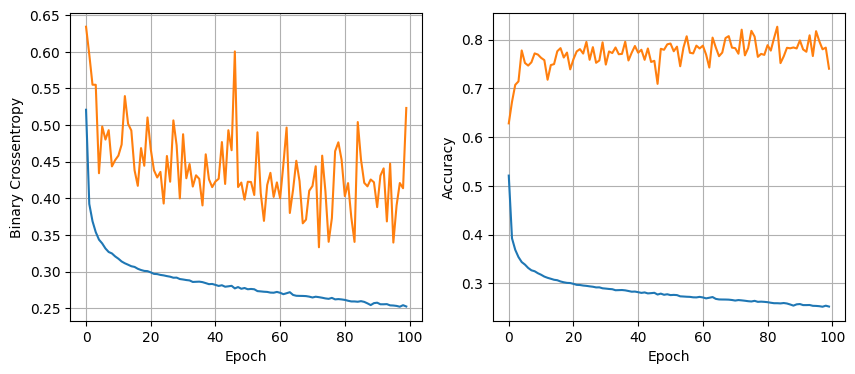

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8676 - loss: 0.3460  
nodes: 32, droupout: 0.2, lr: 0.01, batch size 32


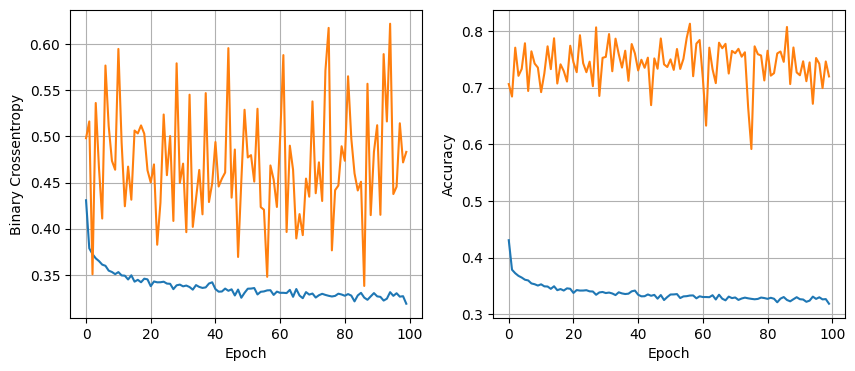

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8596 - loss: 0.3241  
nodes: 32, droupout: 0.2, lr: 0.01, batch size 64


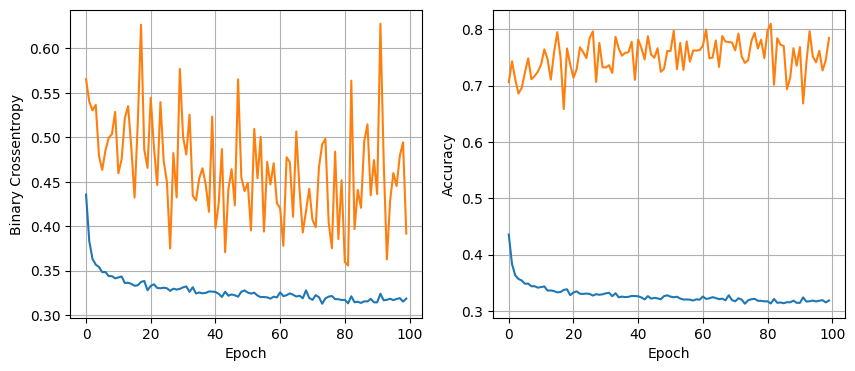

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8692 - loss: 0.3119  
nodes: 32, droupout: 0.2, lr: 0.01, batch size 128


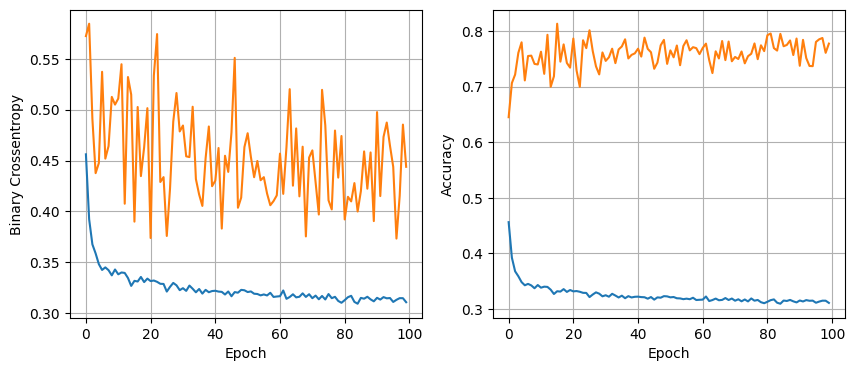

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8763 - loss: 0.3135
nodes: 32, droupout: 0.2, lr: 0.005, batch size 32


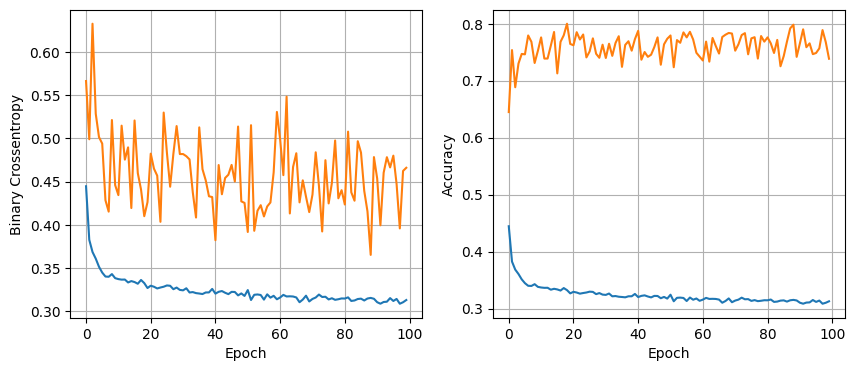

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8728 - loss: 0.3119
nodes: 32, droupout: 0.2, lr: 0.005, batch size 64


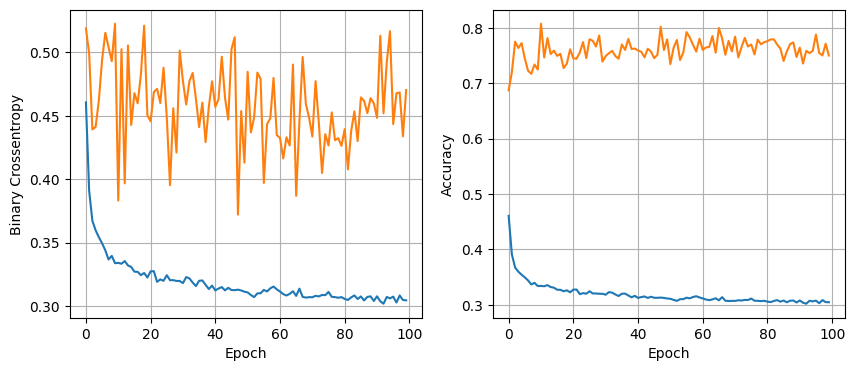

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8720 - loss: 0.3108  
nodes: 32, droupout: 0.2, lr: 0.005, batch size 128


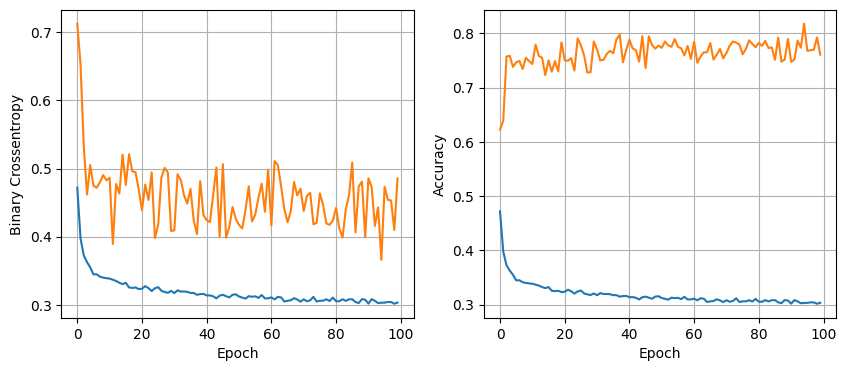

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8711 - loss: 0.3139  
nodes: 32, droupout: 0.2, lr: 0.001, batch size 32


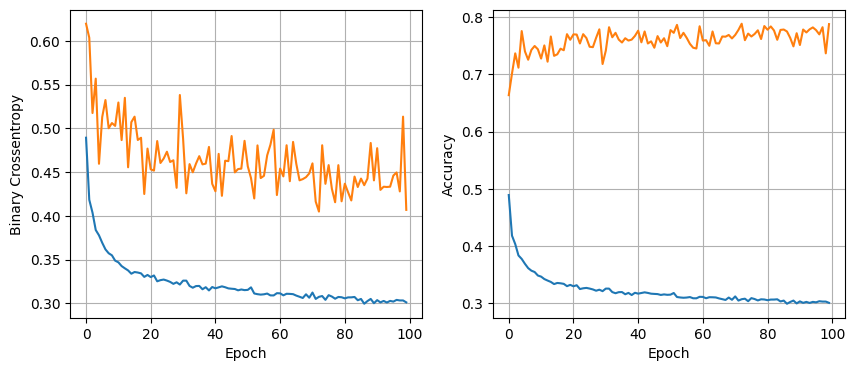

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8842 - loss: 0.3018  
nodes: 32, droupout: 0.2, lr: 0.001, batch size 64


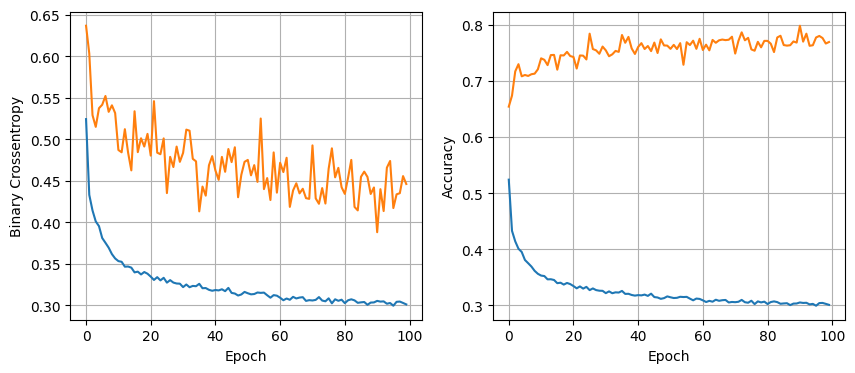

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8743 - loss: 0.3074  
nodes: 32, droupout: 0.2, lr: 0.001, batch size 128


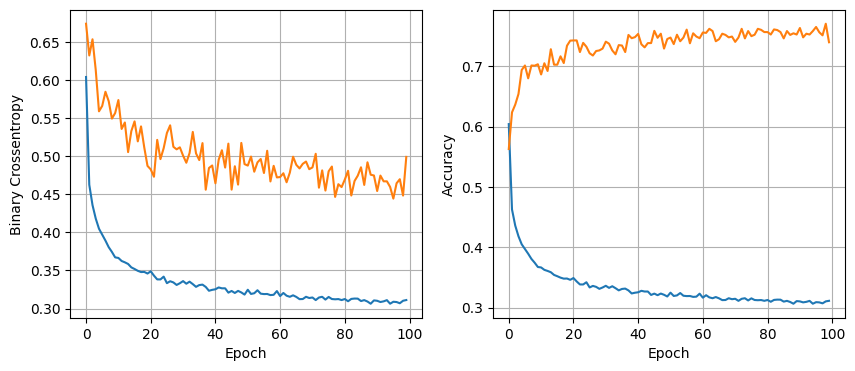

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8728 - loss: 0.3030  
nodes: 64, droupout: 0, lr: 0.01, batch size 32


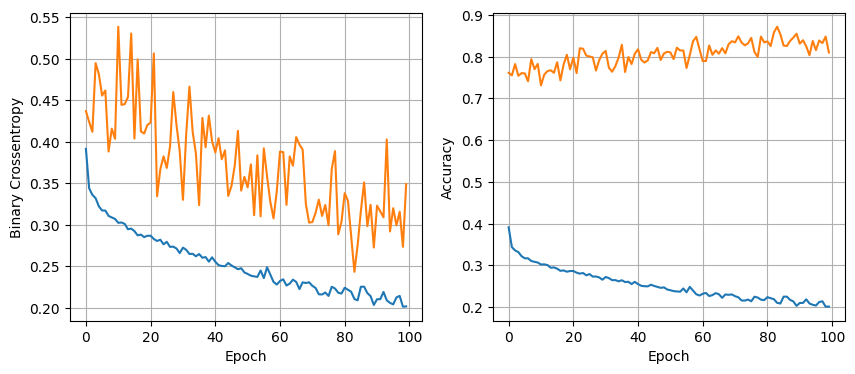

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8608 - loss: 0.4864  
nodes: 64, droupout: 0, lr: 0.01, batch size 64


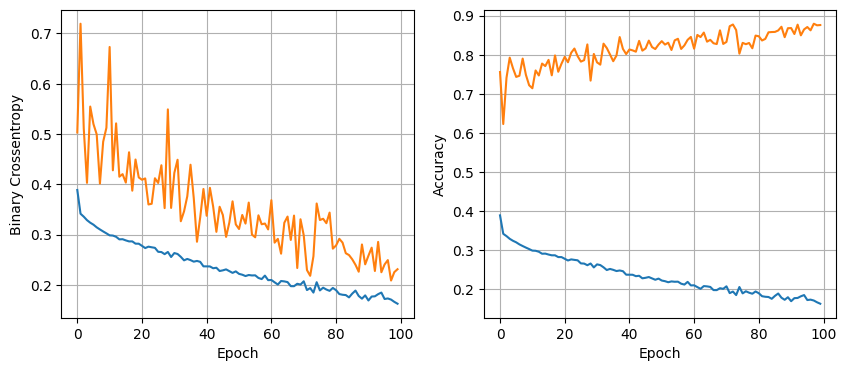

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8701 - loss: 0.5412  
nodes: 64, droupout: 0, lr: 0.01, batch size 128


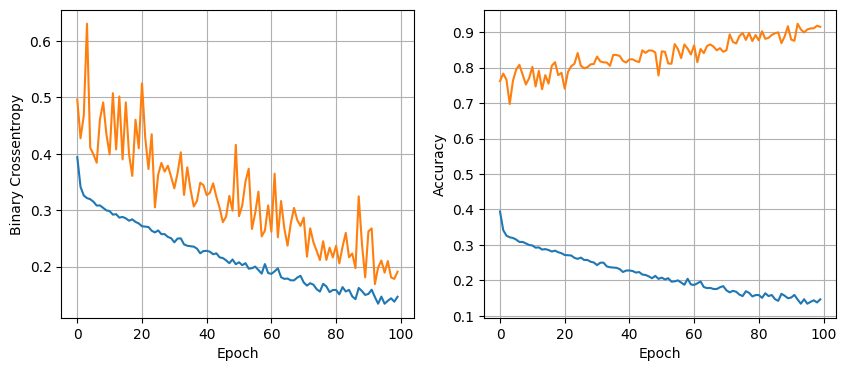

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8499 - loss: 0.6229  
nodes: 64, droupout: 0, lr: 0.005, batch size 32


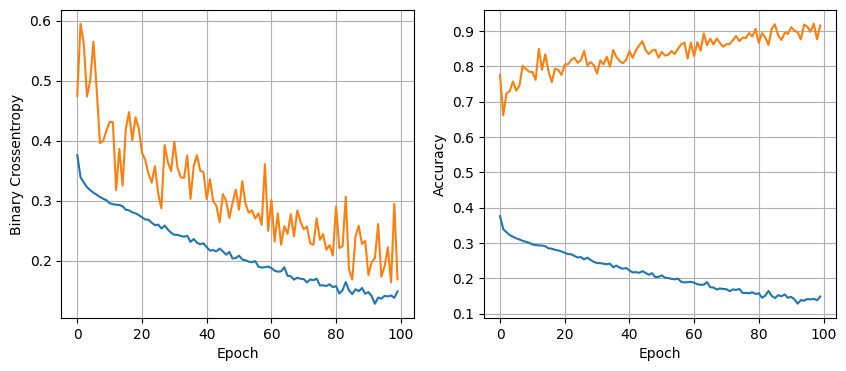

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8532 - loss: 0.7343  
nodes: 64, droupout: 0, lr: 0.005, batch size 64


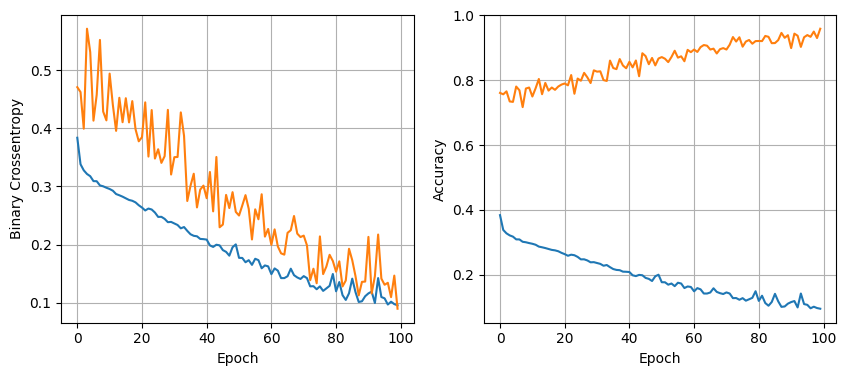

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8491 - loss: 0.9177  
nodes: 64, droupout: 0, lr: 0.005, batch size 128


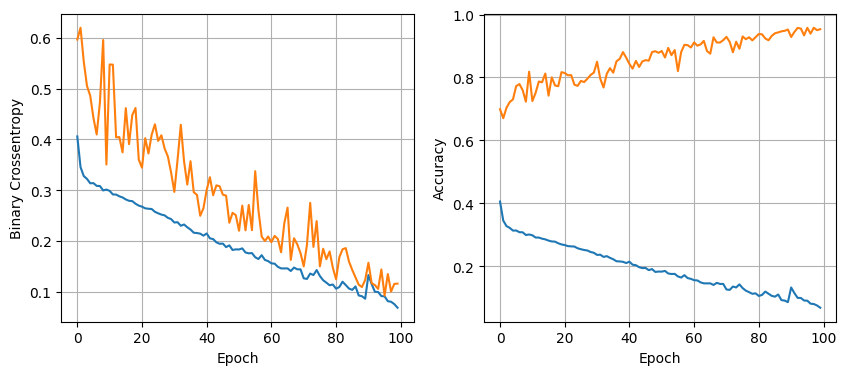

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8548 - loss: 0.8845  
nodes: 64, droupout: 0, lr: 0.001, batch size 32


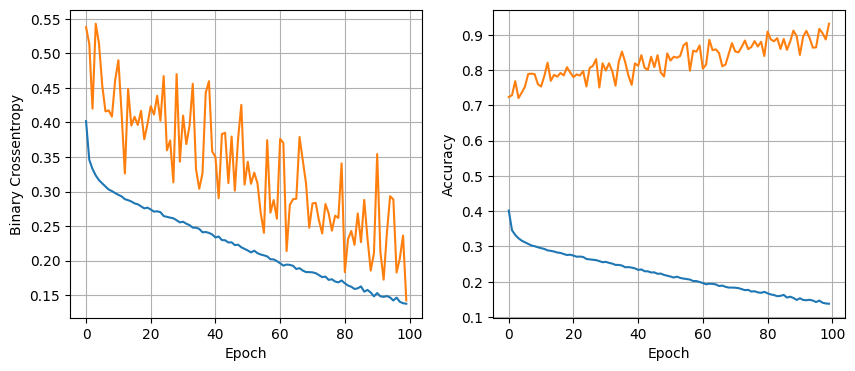

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8592 - loss: 0.5193
nodes: 64, droupout: 0, lr: 0.001, batch size 64


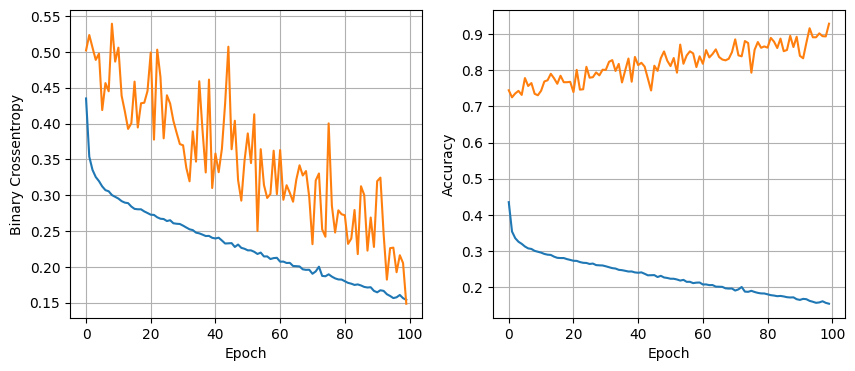

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8607 - loss: 0.4812  
nodes: 64, droupout: 0, lr: 0.001, batch size 128


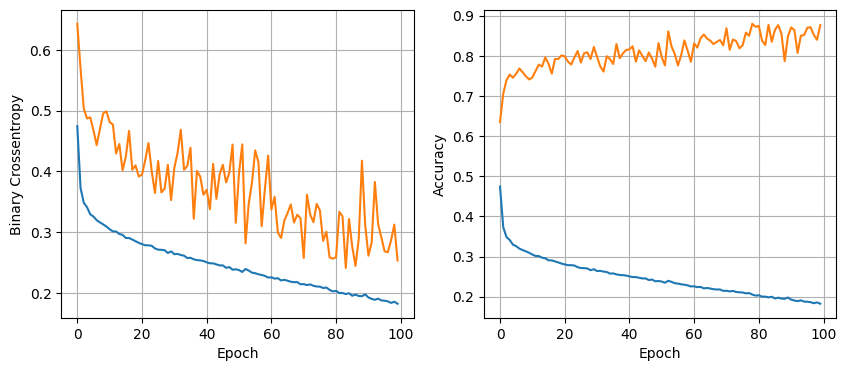

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8721 - loss: 0.3963
nodes: 64, droupout: 0.2, lr: 0.01, batch size 32


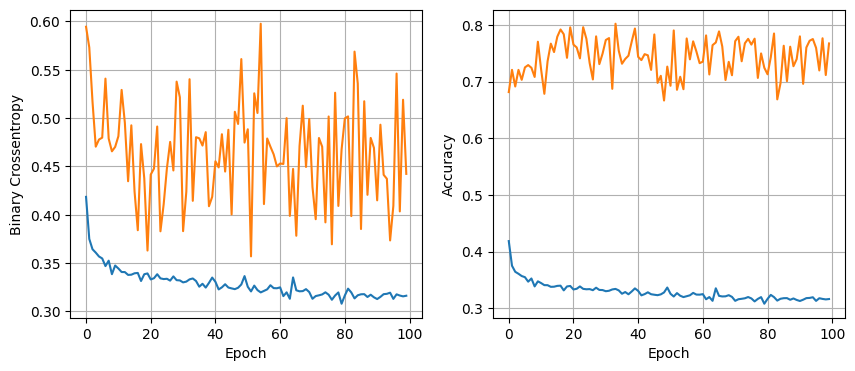

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8745 - loss: 0.3226  
nodes: 64, droupout: 0.2, lr: 0.01, batch size 64


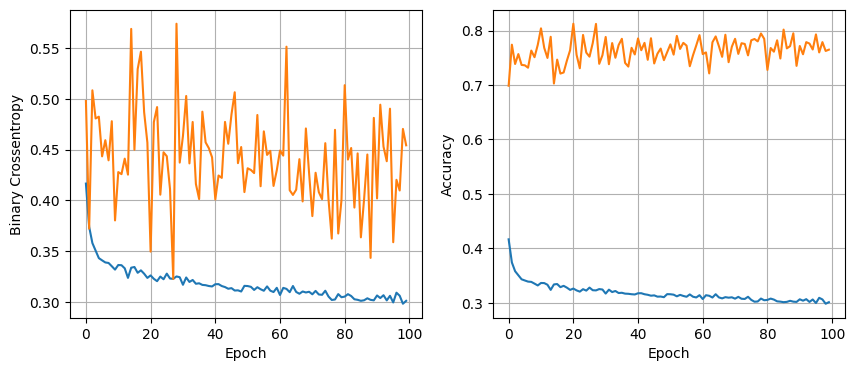

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8712 - loss: 0.3283  
nodes: 64, droupout: 0.2, lr: 0.01, batch size 128


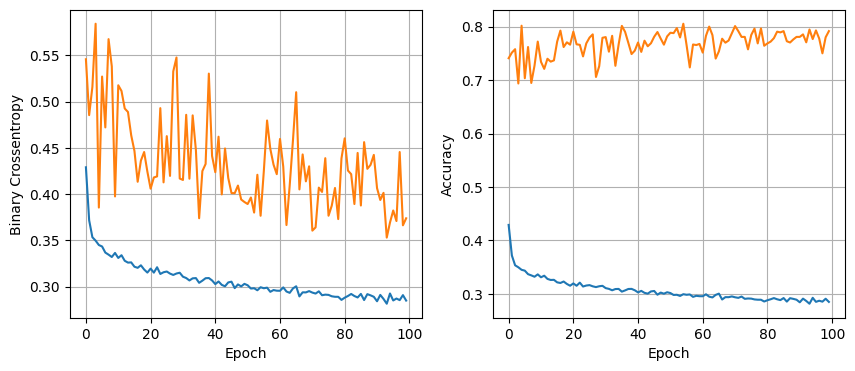

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8775 - loss: 0.3070
nodes: 64, droupout: 0.2, lr: 0.005, batch size 32


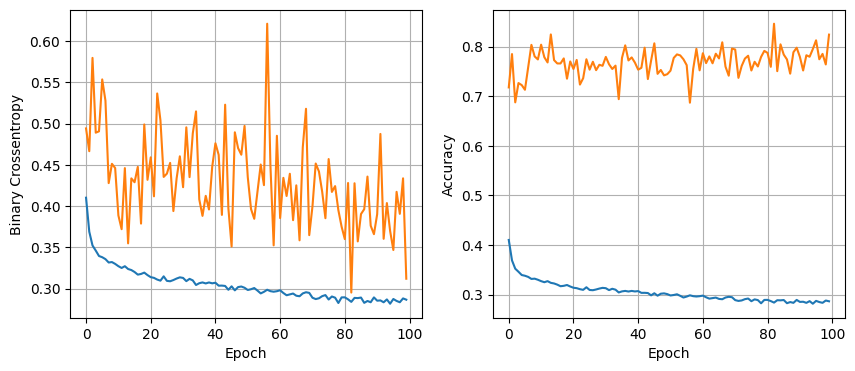

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8775 - loss: 0.3162  
nodes: 64, droupout: 0.2, lr: 0.005, batch size 64


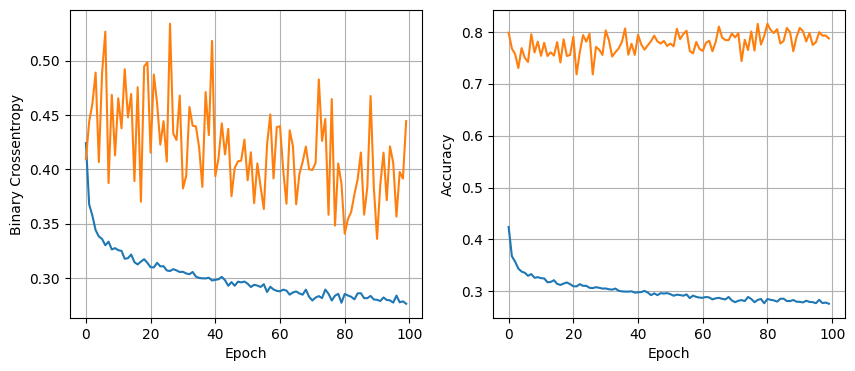

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8756 - loss: 0.3361  
nodes: 64, droupout: 0.2, lr: 0.005, batch size 128


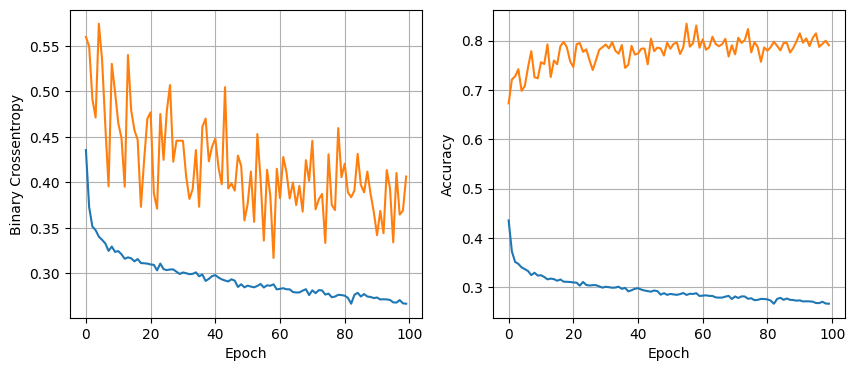

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8772 - loss: 0.3051  
nodes: 64, droupout: 0.2, lr: 0.001, batch size 32


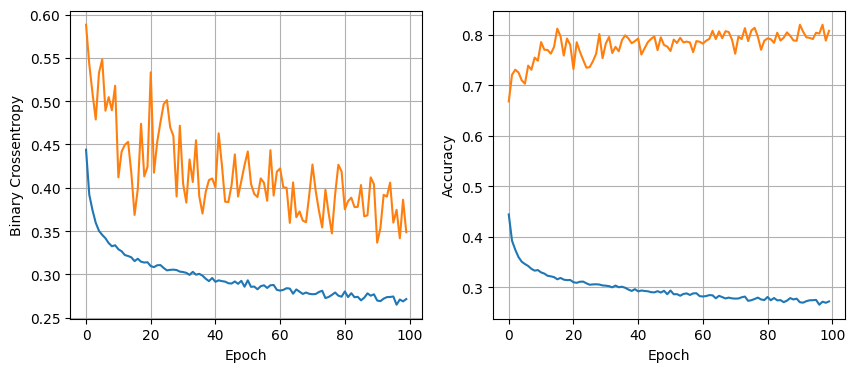

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8795 - loss: 0.3065
nodes: 64, droupout: 0.2, lr: 0.001, batch size 64


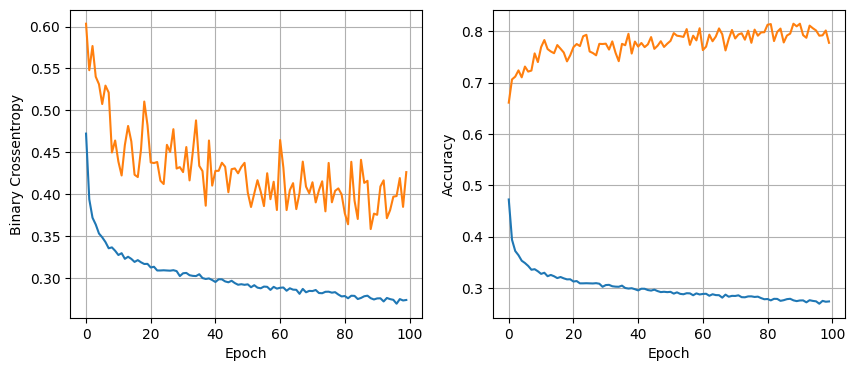

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8785 - loss: 0.3074
nodes: 64, droupout: 0.2, lr: 0.001, batch size 128


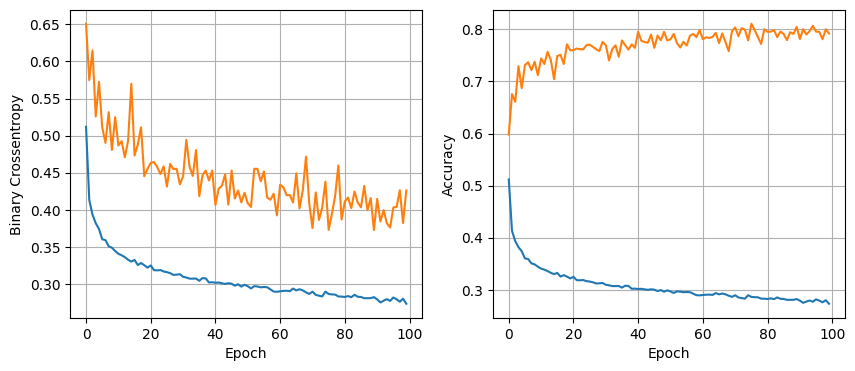

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8802 - loss: 0.3028
nodes: 128, droupout: 0, lr: 0.01, batch size 32


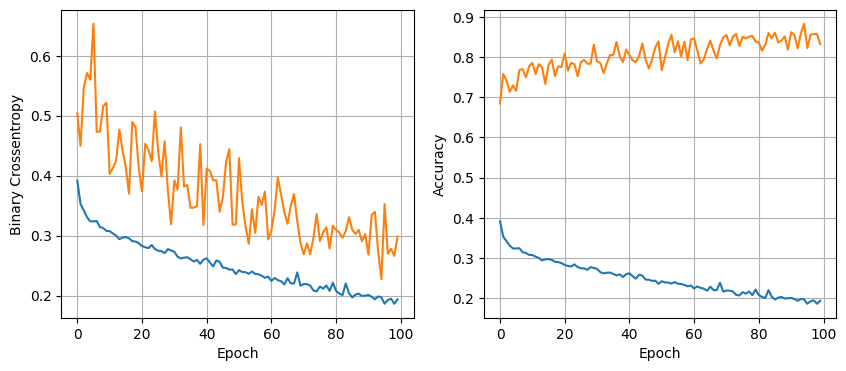

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8746 - loss: 0.4364  
nodes: 128, droupout: 0, lr: 0.01, batch size 64


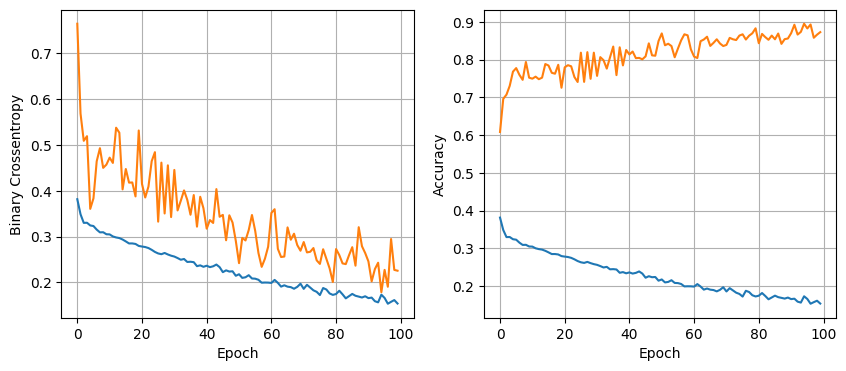

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8694 - loss: 0.7289
nodes: 128, droupout: 0, lr: 0.01, batch size 128


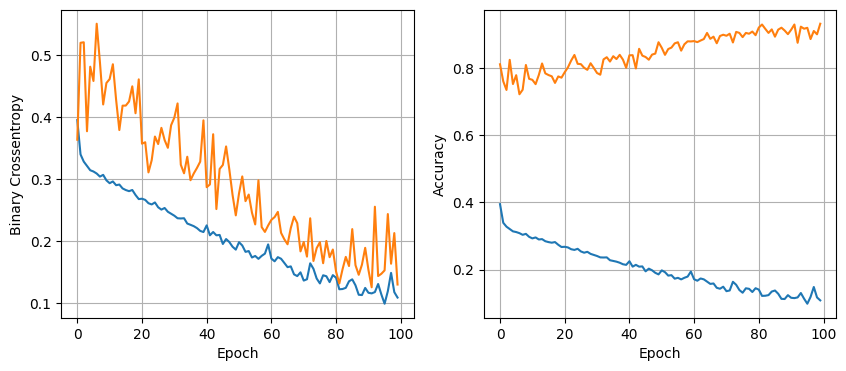

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8573 - loss: 0.8815
nodes: 128, droupout: 0, lr: 0.005, batch size 32


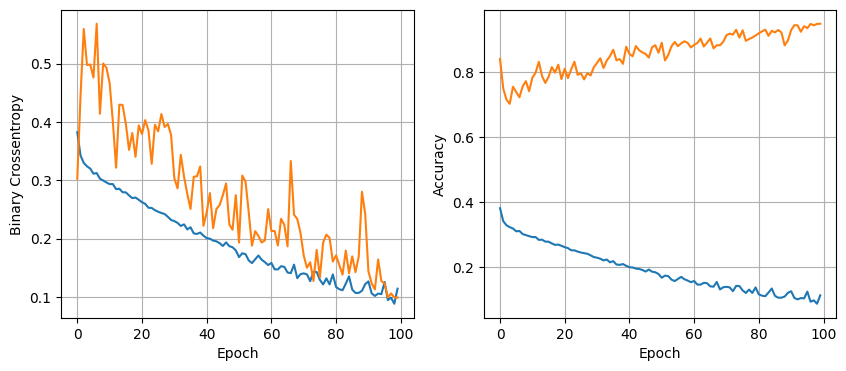

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8565 - loss: 0.9659  
nodes: 128, droupout: 0, lr: 0.005, batch size 64


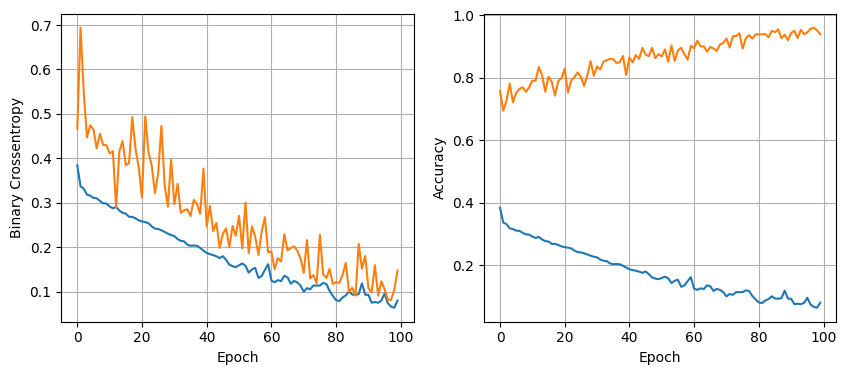

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8559 - loss: 1.1564  
nodes: 128, droupout: 0, lr: 0.005, batch size 128


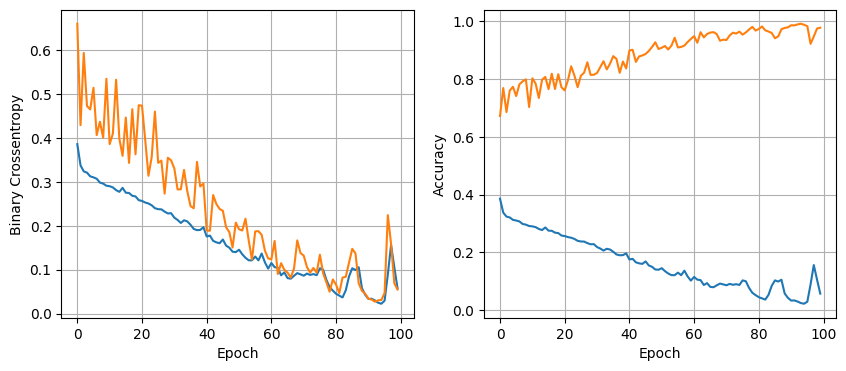

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8660 - loss: 0.9750  
nodes: 128, droupout: 0, lr: 0.001, batch size 32


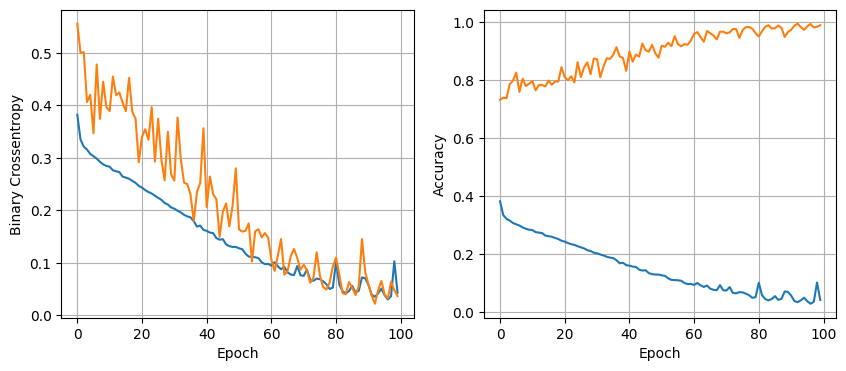

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8610 - loss: 0.9516  
nodes: 128, droupout: 0, lr: 0.001, batch size 64


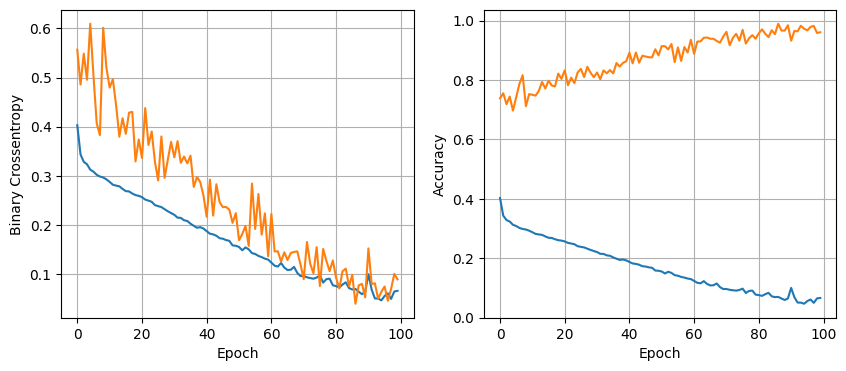

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8541 - loss: 0.8096
nodes: 128, droupout: 0, lr: 0.001, batch size 128


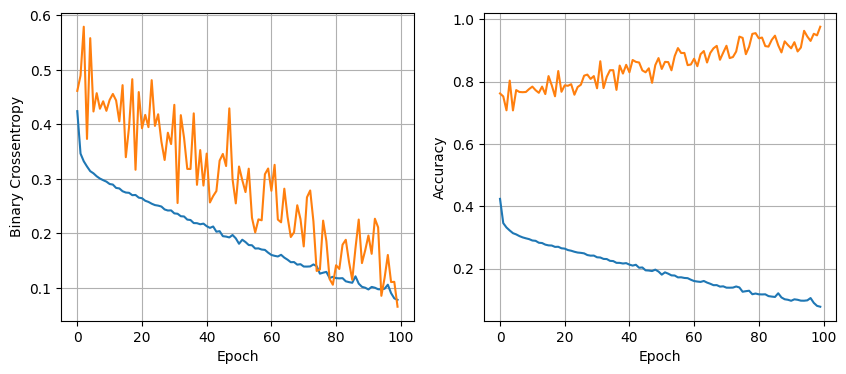

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8608 - loss: 0.5918  
nodes: 128, droupout: 0.2, lr: 0.01, batch size 32


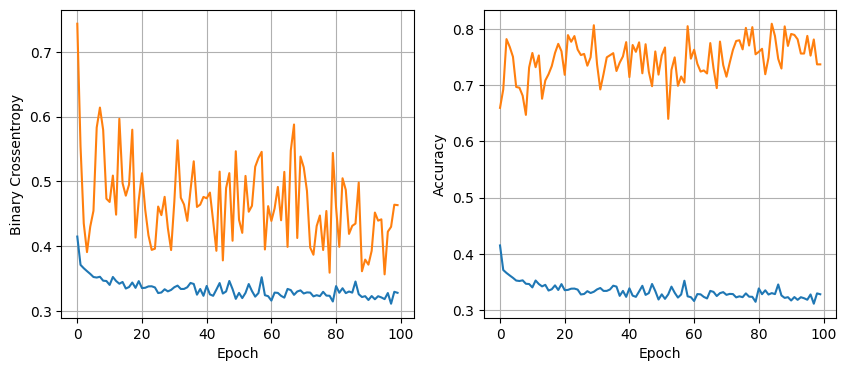

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8697 - loss: 0.3185  
nodes: 128, droupout: 0.2, lr: 0.01, batch size 64


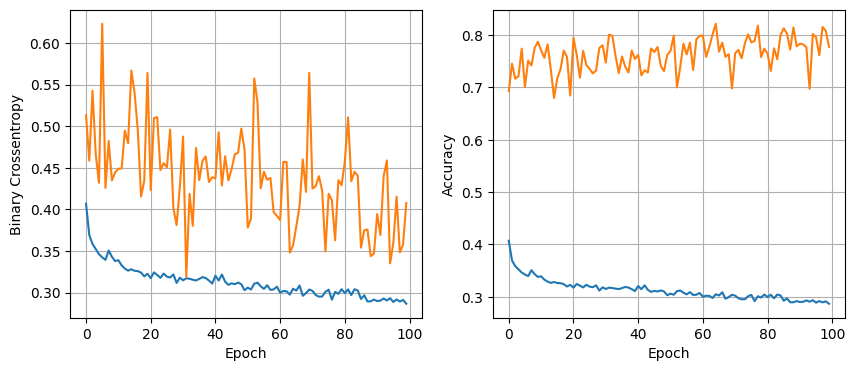

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8773 - loss: 0.3275  
nodes: 128, droupout: 0.2, lr: 0.01, batch size 128


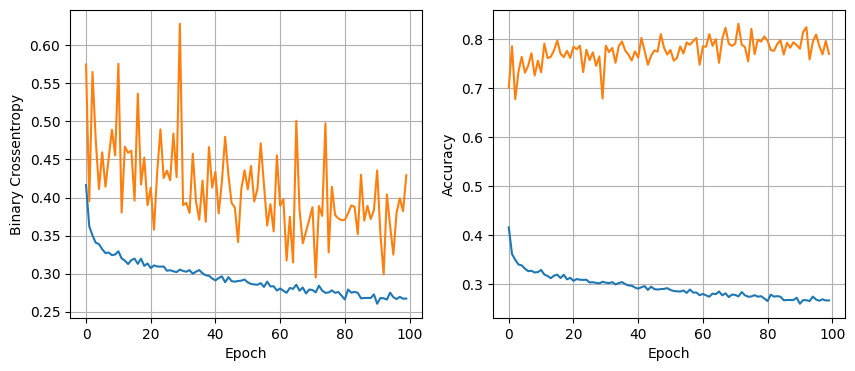

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8732 - loss: 0.3524  
nodes: 128, droupout: 0.2, lr: 0.005, batch size 32


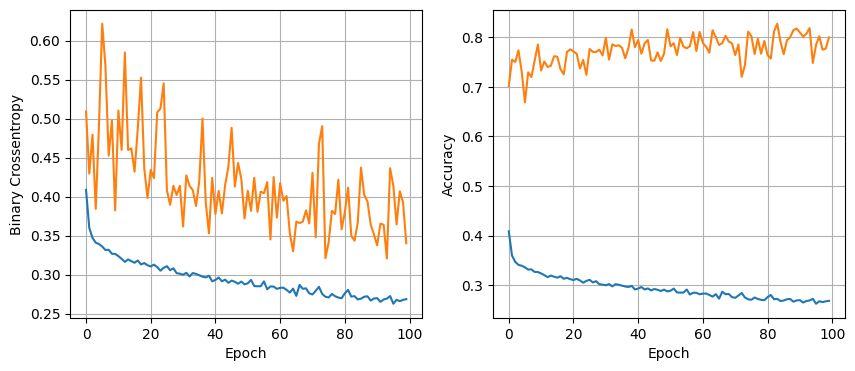

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8775 - loss: 0.3326  
nodes: 128, droupout: 0.2, lr: 0.005, batch size 64


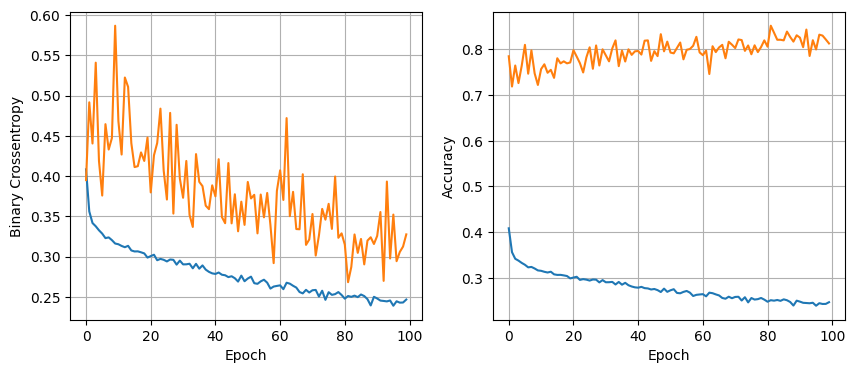

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8814 - loss: 0.3334
nodes: 128, droupout: 0.2, lr: 0.005, batch size 128


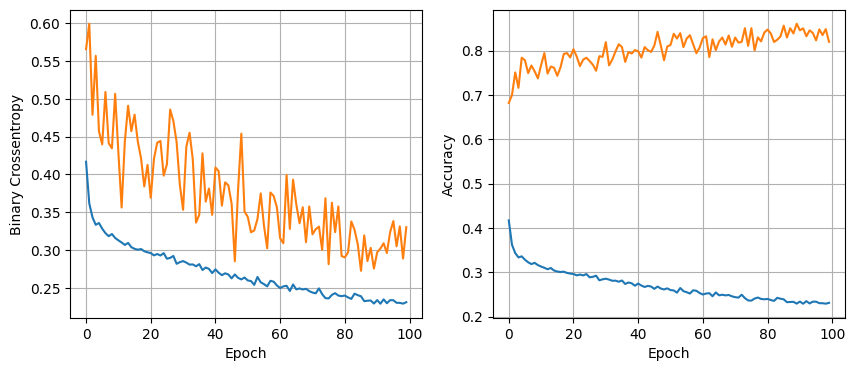

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8759 - loss: 0.3439  
nodes: 128, droupout: 0.2, lr: 0.001, batch size 32


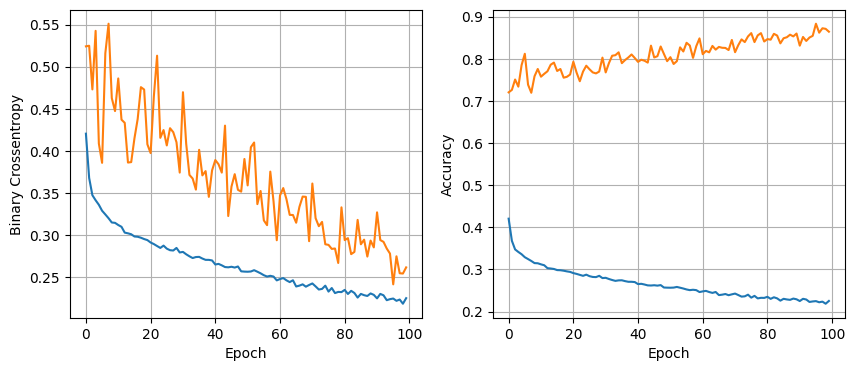

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8780 - loss: 0.3425  
nodes: 128, droupout: 0.2, lr: 0.001, batch size 64


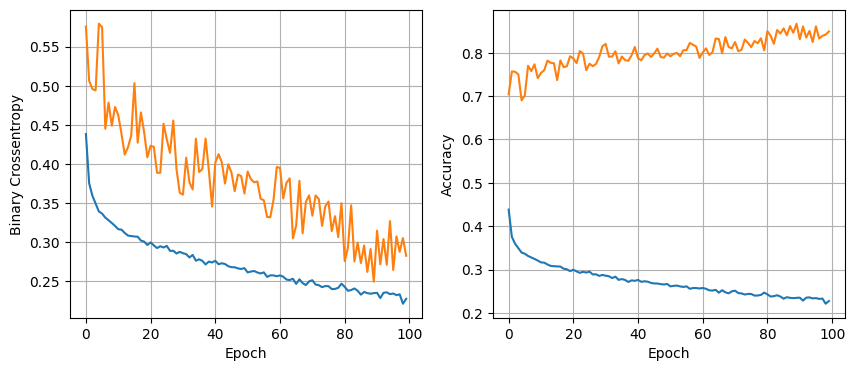

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8779 - loss: 0.3465  
nodes: 128, droupout: 0.2, lr: 0.001, batch size 128


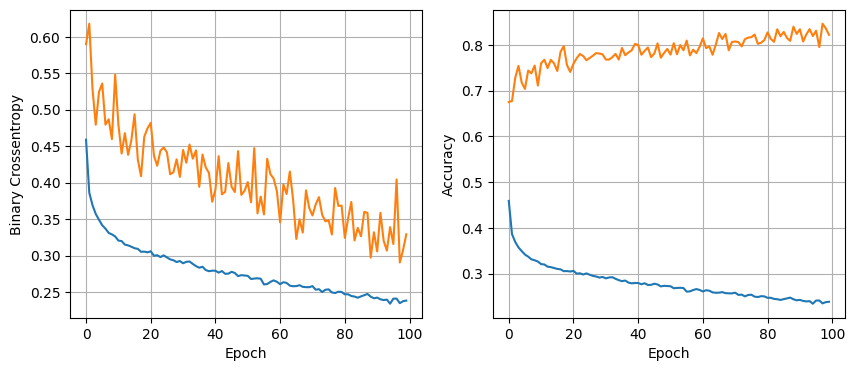

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8801 - loss: 0.3247  


In [18]:
least_val_lost = float('inf')
least_loss_model = None
epochs= 100 
for nodes in [16, 32, 64, 128]:
    for dropout_prob in [0, 0.2]:
        for lr in [0.01, 0.005, 0.001]:
            for batch_size in [32, 64, 128]:
                print(
                    f"nodes: {nodes}, droupout: {dropout_prob}, lr: {lr}, batch size {batch_size}"
                )
                model, history = train_model(
                    X_train=X_train, y_train=y_train, n_nodes=nodes, dropout_prob=dropout_prob, lr=lr, 
                    batch_size=batch_size, epochs=epochs
                )
                plot_history(history)
                val_loss = model.evaluate(X_val, y_val)[0]
                if val_loss < least_val_lost:
                    least_val_lost = val_loss
                    least_loss_model = model

In [20]:
least_val_lost

0.3060430884361267